In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import time
from tensorflow.keras.optimizers import Adam


In [2]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [3]:
import os  # Add this line at the beginning of your code

save_dir = '/kaggle/working/'  # Specify your directory path
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist


In [4]:
# Batch size and learning rate
batch_size = 32  # Batch size set to 32
epochs = 200
latent_dim = 100

# Optimizers
opt_autoencoder = Adam(learning_rate=0.0001, beta_1=0.5)
opt_disc = Adam(learning_rate=0.0001, beta_1=0.5)


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split

# Paths to the dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'  
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'  
metadata_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'  


# Load metadata CSV
labels = pd.read_csv(metadata_file)

# Convert diagnosis (dx) to integers (you can map specific diseases if needed)
label_mapping = {label: idx for idx, label in enumerate(labels['dx'].unique())}
labels['dx'] = labels['dx'].map(label_mapping)

# Set image size for the model
IMG_SIZE = 64  # Resize images to 64x64

# Function to load and preprocess images
def load_images_and_labels(labels, image_dir_1, image_dir_2, img_size=64):
    images = []
    label_list = []

    for _, row in labels.iterrows():
        # Get the file path for the image
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        # Check if the image exists in part 1 or part 2
        if os.path.exists(file_path_1):
            img = image.load_img(file_path_1, target_size=(img_size, img_size))
        elif os.path.exists(file_path_2):
            img = image.load_img(file_path_2, target_size=(img_size, img_size))
        else:
            continue  # Skip if image file is missing

        # Convert image to numpy array and normalize it
        img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
        label_list.append(row['dx'])  # Add the label (dx)

    X = np.array(images)  # Shape: (num_samples, img_size, img_size, 3)
    y = np.array(label_list)  # Labels: [0, 1, 2, ..., 6] for classification
    return X, y

# Load the images and labels
X, y = load_images_and_labels(labels, image_dir_1, image_dir_2, IMG_SIZE)

# Step 1: Split into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the 80% training set into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Check the shape of the dataset
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=7)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Create the data pipeline
def create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size):
    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
    val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot))
    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

    # Efficient data pipeline: cache, batch, and prefetch
    train_data = (train_data
                  .cache()
                  .shuffle(buffer_size=1000)
                  .batch(batch_size)
                  .prefetch(tf.data.experimental.AUTOTUNE))
    
    val_data = (val_data
                .cache()
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

    test_data = (test_data
                 .cache()
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))

    return train_data, val_data, test_data

# Set batch size for training
batch_size = 32

# Create the dataset pipeline
train_data, val_data, test_data = create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size)


Training set shape: (6409, 64, 64, 3)
Validation set shape: (1603, 64, 64, 3)
Test set shape: (2003, 64, 64, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

latent_dim = 128

# Encoder (Simplified)
encoder = tf.keras.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=3, strides=2, padding="valid"),  # Changed padding to 'valid' and kernel size to 3
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, kernel_size=3, strides=2, padding="valid"),  # Kernel size 3 and valid padding
    layers.LeakyReLU(0.2),
    layers.Conv2D(256, kernel_size=3, strides=2, padding="valid"),  # Kernel size 3 and valid padding
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation
])

# Decoder with adjusted Conv2DTranspose layers
decoder = tf.keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),  # Upscale to (8, 8, 128)
    layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation='relu'),  # (16, 16, 128)
    layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation='relu'),  # (32, 32, 64)
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation='relu'),  # (64, 64, 32)
    layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation='sigmoid'),  # (64, 64, 3)
])

# Full autoencoder model
autoencoder_input = layers.Input(shape=(64, 64, 3))
latent_representation = encoder(autoencoder_input)
reconstructed_image = decoder(latent_representation)

autoencoder = models.Model(inputs=autoencoder_input, outputs=reconstructed_image)

# Compile the autoencoder model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Print model summary to check the architecture
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128)                 │       1,976,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 64, 64, 3)           │       1,297,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,274,051 (12.49 MB)

 Trainable params: 3,274,051 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras import layers, models
import tensorflow as tf

def create_optimized_model_no_padding():
    inputs = tf.keras.Input(shape=(64, 64, 3))
    
    # First Convolutional Block with valid padding (no padding)
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='valid')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)  # Output shape: (31, 31, 32)
    
    # Second Convolutional Block with valid padding (no padding)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='valid')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)  # Output shape: (14, 14, 64)
   
    # Flatten the feature map
    x = tf.keras.layers.Flatten()(x)

    # Dense Layers
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Reduced number of neurons
    x = tf.keras.layers.Dropout(0.3)(x)  # Slightly reduced dropout
    x = tf.keras.layers.Dense(64, activation='relu')(x)  # Reduced number of neurons
    x = tf.keras.layers.Dropout(0.4)(x)   
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)  # 7 output classes (for HAM10000 dataset)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create an instance of the model
discriminator = create_optimized_model_no_padding()

# Compile the model
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to verify the changes
discriminator.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,633,863 (6.23 MB)

 Trainable params: 1,633,863 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

# Loss functions
loss_fn_auto = tf.keras.losses.MeanSquaredError()  # Autoencoder Loss for reconstruction
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy()  # Discriminator Loss for multi-class classification

# Optimizers
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)  # Optimizer for Autoencoder
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)  # Optimizer for Discriminator

# Compile the autoencoder model
autoencoder.compile(optimizer=opt_autoencoder, loss=loss_fn_auto)

# Compile the discriminator model (since it’s for classification, we use categorical crossentropy)
discriminator.compile(optimizer=opt_disc, loss=loss_fn_disc, metrics=['accuracy'])

# Print model summaries to check
print("Autoencoder Model Summary:")
autoencoder.summary()

print("\nDiscriminator Model Summary:")
discriminator.summary()


Autoencoder Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128)                 │       1,976,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 64, 64, 3)           │       1,297,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,274,051 (12.49 MB)

 Trainable params: 3,274,051 (12.49 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,633,863 (6.23 MB)

 Trainable params: 1,633,863 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tqdm import tqdm


In [10]:
# Ensure the batch is passed from the dataset
for idx, (batch_real, batch_label) in enumerate(tqdm(train_data)):  # Assuming `train_data` is the dataset

    # Pass batch through the encoder and decoder (autoencoder)
    latent_representation = encoder(batch_real)
    generated_image = decoder(latent_representation)

    # Check if the shape is as expected
    print(f"Generated image shape: {generated_image.shape}")
    print(f"Batch real image shape: {batch_real.shape}")

    # If needed, resize generated image to match batch_real shape
    generated_image = tf.image.resize(generated_image, (64, 64))  # Resize to match (64, 64, 3)
    loss_autoencoder = loss_fn_auto(batch_real, generated_image)  # Calculate the loss


  0%|          | 1/201 [00:01<05:18,  1.59s/it]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)


  7%|▋         | 15/201 [00:01<00:14, 12.79it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 14%|█▍        | 29/201 [00:02<00:06, 27.31it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 21%|██▏       | 43/201 [00:02<00:03, 40.82it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 28%|██▊       | 57/201 [00:02<00:02, 50.59it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 35%|███▌      | 71/201 [00:02<00:02, 56.45it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 42%|████▏     | 85/201 [00:02<00:01, 60.64it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 46%|████▌     | 92/201 [00:03<00:01, 59.15it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)


 53%|█████▎    | 106/201 [00:03<00:01, 60.64it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 60%|█████▉    | 120/201 [00:03<00:01, 62.04it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 67%|██████▋   | 134/201 [00:03<00:01, 62.45it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)


 73%|███████▎  | 147/201 [00:03<00:00, 57.98it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)


 80%|████████  | 161/201 [00:04<00:00, 62.17it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 87%|████████▋ | 175/201 [00:04<00:00, 64.59it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 94%|█████████▍| 189/201 [00:04<00:00, 65.38it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real im

 98%|█████████▊| 196/201 [00:04<00:00, 66.19it/s]

Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)
Generated image shape: (32, 64, 64, 3)
Batch real image shape: (32, 64, 64, 3)


100%|██████████| 201/201 [00:04<00:00, 41.10it/s]

Generated image shape: (9, 64, 64, 3)
Batch real image shape: (9, 64, 64, 3)


In [11]:
# Training loop for GAN
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

for epoch in range(200):
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_data)):
        with tf.GradientTape() as autoencoder_tape, tf.GradientTape() as disc_tape:
            # Pass batch through the encoder and decoder (autoencoder)
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)

            # Pass batch through the discriminator (real vs fake image)
            fake = generated_image
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Apply gradients to autoencoder
        grads_autoencoder = autoencoder_tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        # Apply gradients to discriminator
        grads_discriminator = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())
        
        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop
    for val_batch_real, val_batch_label in val_data:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics
    print(f"Epoch {epoch}, Autoencoder Loss: {avg_autoencoder_loss}, Discriminator Loss: {avg_discriminator_loss}, Discriminator Accuracy: {avg_discriminator_acc}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss}, Discriminator Loss: {avg_val_discriminator_loss}, Discriminator Accuracy: {avg_val_discriminator_acc}")


100%|██████████| 201/201 [00:38<00:00,  5.20it/s]


Epoch 0, Autoencoder Loss: 0.022196905687451363, Discriminator Loss: 1.124599575996399, Discriminator Accuracy: 0.6725572943687439
Validation - Autoencoder Loss: 0.01742633804678917, Discriminator Loss: 1.0709171295166016, Discriminator Accuracy: 0.6607434749603271


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 1, Autoencoder Loss: 0.013417000882327557, Discriminator Loss: 1.0461729764938354, Discriminator Accuracy: 0.6721599698066711
Validation - Autoencoder Loss: 0.00980500876903534, Discriminator Loss: 1.023828387260437, Discriminator Accuracy: 0.6607434749603271


100%|██████████| 201/201 [00:36<00:00,  5.48it/s]


Epoch 2, Autoencoder Loss: 0.007382956333458424, Discriminator Loss: 0.9637231826782227, Discriminator Accuracy: 0.6725400686264038
Validation - Autoencoder Loss: 0.005414201412349939, Discriminator Loss: 0.9451804161071777, Discriminator Accuracy: 0.6613562107086182


100%|██████████| 201/201 [00:37<00:00,  5.42it/s]


Epoch 3, Autoencoder Loss: 0.005196822807192802, Discriminator Loss: 0.9292572140693665, Discriminator Accuracy: 0.6743366122245789
Validation - Autoencoder Loss: 0.004783232230693102, Discriminator Loss: 0.922218382358551, Discriminator Accuracy: 0.664419949054718


100%|██████████| 201/201 [00:37<00:00,  5.38it/s]


Epoch 4, Autoencoder Loss: 0.004391098860651255, Discriminator Loss: 0.9066104292869568, Discriminator Accuracy: 0.6772042512893677
Validation - Autoencoder Loss: 0.005328956060111523, Discriminator Loss: 0.9089334011077881, Discriminator Accuracy: 0.6809640526771545


100%|██████████| 201/201 [00:37<00:00,  5.38it/s]


Epoch 5, Autoencoder Loss: 0.003975544590502977, Discriminator Loss: 0.8846549391746521, Discriminator Accuracy: 0.6849951148033142
Validation - Autoencoder Loss: 0.004051829222589731, Discriminator Loss: 0.9236658811569214, Discriminator Accuracy: 0.665032684803009


100%|██████████| 201/201 [00:37<00:00,  5.39it/s]


Epoch 6, Autoencoder Loss: 0.003609195351600647, Discriminator Loss: 0.8646060824394226, Discriminator Accuracy: 0.6897111535072327
Validation - Autoencoder Loss: 0.003380856942385435, Discriminator Loss: 0.8926507830619812, Discriminator Accuracy: 0.6815768480300903


100%|██████████| 201/201 [00:37<00:00,  5.39it/s]


Epoch 7, Autoencoder Loss: 0.003434059675782919, Discriminator Loss: 0.8436510562896729, Discriminator Accuracy: 0.6965692043304443
Validation - Autoencoder Loss: 0.003322663251310587, Discriminator Loss: 0.8848072290420532, Discriminator Accuracy: 0.6754493713378906


100%|██████████| 201/201 [00:37<00:00,  5.38it/s]


Epoch 8, Autoencoder Loss: 0.0031836489215493202, Discriminator Loss: 0.8249941468238831, Discriminator Accuracy: 0.7025635242462158
Validation - Autoencoder Loss: 0.003426856826990843, Discriminator Loss: 0.8670246005058289, Discriminator Accuracy: 0.6693218946456909


100%|██████████| 201/201 [00:37<00:00,  5.36it/s]


Epoch 9, Autoencoder Loss: 0.00305131240747869, Discriminator Loss: 0.8053818345069885, Discriminator Accuracy: 0.7060530185699463
Validation - Autoencoder Loss: 0.0030655618757009506, Discriminator Loss: 0.8683783411979675, Discriminator Accuracy: 0.6748366355895996


100%|██████████| 201/201 [00:37<00:00,  5.31it/s]


Epoch 10, Autoencoder Loss: 0.0029167775064706802, Discriminator Loss: 0.7939195036888123, Discriminator Accuracy: 0.7121337652206421
Validation - Autoencoder Loss: 0.0028811204247176647, Discriminator Loss: 0.8328848481178284, Discriminator Accuracy: 0.693219006061554


100%|██████████| 201/201 [00:37<00:00,  5.37it/s]


Epoch 11, Autoencoder Loss: 0.0028530252166092396, Discriminator Loss: 0.77543705701828, Discriminator Accuracy: 0.7135156989097595
Validation - Autoencoder Loss: 0.00286843441426754, Discriminator Loss: 0.8388363122940063, Discriminator Accuracy: 0.6864787936210632


100%|██████████| 201/201 [00:37<00:00,  5.38it/s]


Epoch 12, Autoencoder Loss: 0.0027398185338824987, Discriminator Loss: 0.7637431025505066, Discriminator Accuracy: 0.7196483016014099
Validation - Autoencoder Loss: 0.002880527637898922, Discriminator Loss: 0.8220487833023071, Discriminator Accuracy: 0.696282684803009


100%|██████████| 201/201 [00:36<00:00,  5.45it/s]


Epoch 13, Autoencoder Loss: 0.0027007493190467358, Discriminator Loss: 0.7498680353164673, Discriminator Accuracy: 0.7240878343582153
Validation - Autoencoder Loss: 0.0026173617225140333, Discriminator Loss: 0.8130874633789062, Discriminator Accuracy: 0.6889297366142273


100%|██████████| 201/201 [00:36<00:00,  5.45it/s]


Epoch 14, Autoencoder Loss: 0.0026116848457604647, Discriminator Loss: 0.7416440844535828, Discriminator Accuracy: 0.7245715856552124
Validation - Autoencoder Loss: 0.003001085016876459, Discriminator Loss: 0.807411253452301, Discriminator Accuracy: 0.6987336874008179


100%|██████████| 201/201 [00:36<00:00,  5.48it/s]


Epoch 15, Autoencoder Loss: 0.0025833332911133766, Discriminator Loss: 0.7323054075241089, Discriminator Accuracy: 0.7266445755958557
Validation - Autoencoder Loss: 0.002643641084432602, Discriminator Loss: 0.8182340860366821, Discriminator Accuracy: 0.693831741809845


100%|██████████| 201/201 [00:36<00:00,  5.47it/s]


Epoch 16, Autoencoder Loss: 0.0025378051213920116, Discriminator Loss: 0.7214590311050415, Discriminator Accuracy: 0.7307214140892029
Validation - Autoencoder Loss: 0.0025752082001417875, Discriminator Loss: 0.8022488355636597, Discriminator Accuracy: 0.696282684803009


100%|██████████| 201/201 [00:36<00:00,  5.47it/s]


Epoch 17, Autoencoder Loss: 0.0024580340832471848, Discriminator Loss: 0.7120041251182556, Discriminator Accuracy: 0.7337444424629211
Validation - Autoencoder Loss: 0.002433433197438717, Discriminator Loss: 0.7896251082420349, Discriminator Accuracy: 0.6999591588973999


100%|██████████| 201/201 [00:36<00:00,  5.45it/s]


Epoch 18, Autoencoder Loss: 0.0024449035990983248, Discriminator Loss: 0.708167552947998, Discriminator Accuracy: 0.7350572943687439
Validation - Autoencoder Loss: 0.002424859907478094, Discriminator Loss: 0.7840327024459839, Discriminator Accuracy: 0.7066993713378906


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 19, Autoencoder Loss: 0.0023962093982845545, Discriminator Loss: 0.7007424831390381, Discriminator Accuracy: 0.7374412417411804
Validation - Autoencoder Loss: 0.002367861568927765, Discriminator Loss: 0.7929468154907227, Discriminator Accuracy: 0.695057213306427


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 20, Autoencoder Loss: 0.0023576703388243914, Discriminator Loss: 0.6935732960700989, Discriminator Accuracy: 0.7413452863693237
Validation - Autoencoder Loss: 0.002348913112655282, Discriminator Loss: 0.7894163727760315, Discriminator Accuracy: 0.7030228972434998


100%|██████████| 201/201 [00:36<00:00,  5.44it/s]


Epoch 21, Autoencoder Loss: 0.0023114208597689867, Discriminator Loss: 0.6869192719459534, Discriminator Accuracy: 0.7395660281181335
Validation - Autoencoder Loss: 0.00232811295427382, Discriminator Loss: 0.7870442271232605, Discriminator Accuracy: 0.7024101614952087


100%|██████████| 201/201 [00:36<00:00,  5.43it/s]


Epoch 22, Autoencoder Loss: 0.0022919788025319576, Discriminator Loss: 0.6742877960205078, Discriminator Accuracy: 0.7464932203292847
Validation - Autoencoder Loss: 0.0027774169575423002, Discriminator Loss: 0.8637478947639465, Discriminator Accuracy: 0.6907680034637451


100%|██████████| 201/201 [00:36<00:00,  5.46it/s]


Epoch 23, Autoencoder Loss: 0.00228405580855906, Discriminator Loss: 0.6699851155281067, Discriminator Accuracy: 0.7482033967971802
Validation - Autoencoder Loss: 0.002292701741680503, Discriminator Loss: 0.8074924349784851, Discriminator Accuracy: 0.7060866355895996


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 24, Autoencoder Loss: 0.0021982542239129543, Discriminator Loss: 0.6615102291107178, Discriminator Accuracy: 0.7471150755882263
Validation - Autoencoder Loss: 0.002776893088594079, Discriminator Loss: 0.8078001141548157, Discriminator Accuracy: 0.7024101614952087


100%|██████████| 201/201 [00:36<00:00,  5.46it/s]


Epoch 25, Autoencoder Loss: 0.0022092272993177176, Discriminator Loss: 0.6547029614448547, Discriminator Accuracy: 0.7516928911209106
Validation - Autoencoder Loss: 0.002277638064697385, Discriminator Loss: 0.8229323029518127, Discriminator Accuracy: 0.7048611640930176


100%|██████████| 201/201 [00:36<00:00,  5.47it/s]


Epoch 26, Autoencoder Loss: 0.0021758966613560915, Discriminator Loss: 0.6449291706085205, Discriminator Accuracy: 0.7566853165626526
Validation - Autoencoder Loss: 0.0024594771675765514, Discriminator Loss: 0.819940447807312, Discriminator Accuracy: 0.7048611640930176


100%|██████████| 201/201 [00:36<00:00,  5.48it/s]


Epoch 27, Autoencoder Loss: 0.0021513740066438913, Discriminator Loss: 0.6407983899116516, Discriminator Accuracy: 0.7569789886474609
Validation - Autoencoder Loss: 0.0021580613683909178, Discriminator Loss: 0.7809165716171265, Discriminator Accuracy: 0.7146650552749634


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 28, Autoencoder Loss: 0.002140458207577467, Discriminator Loss: 0.6343820095062256, Discriminator Accuracy: 0.7576872706413269
Validation - Autoencoder Loss: 0.0021768142469227314, Discriminator Loss: 0.7750933170318604, Discriminator Accuracy: 0.7171160578727722


100%|██████████| 201/201 [00:36<00:00,  5.45it/s]


Epoch 29, Autoencoder Loss: 0.002107527805492282, Discriminator Loss: 0.6271610260009766, Discriminator Accuracy: 0.7620404958724976
Validation - Autoencoder Loss: 0.0021539130248129368, Discriminator Loss: 0.8029042482376099, Discriminator Accuracy: 0.7011846899986267


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 30, Autoencoder Loss: 0.0020734055433422327, Discriminator Loss: 0.6189119219779968, Discriminator Accuracy: 0.763266921043396
Validation - Autoencoder Loss: 0.0021080337464809418, Discriminator Loss: 0.7826800346374512, Discriminator Accuracy: 0.7109885811805725


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 31, Autoencoder Loss: 0.0020035577472299337, Discriminator Loss: 0.6090578436851501, Discriminator Accuracy: 0.7708160281181335
Validation - Autoencoder Loss: 0.001953982515260577, Discriminator Loss: 0.7721503973007202, Discriminator Accuracy: 0.7091503739356995


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 32, Autoencoder Loss: 0.0018843180732801557, Discriminator Loss: 0.5945812463760376, Discriminator Accuracy: 0.7779677510261536
Validation - Autoencoder Loss: 0.0019684985745698214, Discriminator Loss: 0.8168841600418091, Discriminator Accuracy: 0.7024101614952087


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 33, Autoencoder Loss: 0.00184499635361135, Discriminator Loss: 0.5854368209838867, Discriminator Accuracy: 0.7812327146530151
Validation - Autoencoder Loss: 0.001866972423158586, Discriminator Loss: 0.7728254199028015, Discriminator Accuracy: 0.7201797366142273


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 34, Autoencoder Loss: 0.0018030140781775117, Discriminator Loss: 0.5798981189727783, Discriminator Accuracy: 0.7842040061950684
Validation - Autoencoder Loss: 0.0018282431410625577, Discriminator Loss: 0.7893621325492859, Discriminator Accuracy: 0.7195670008659363


100%|██████████| 201/201 [00:36<00:00,  5.47it/s]


Epoch 35, Autoencoder Loss: 0.0017967099556699395, Discriminator Loss: 0.5720264911651611, Discriminator Accuracy: 0.7861387133598328
Validation - Autoencoder Loss: 0.0018063841853290796, Discriminator Loss: 0.7697369456291199, Discriminator Accuracy: 0.7183415293693542


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 36, Autoencoder Loss: 0.0017896756762638688, Discriminator Loss: 0.5624697804450989, Discriminator Accuracy: 0.7903364896774292
Validation - Autoencoder Loss: 0.0018259233329445124, Discriminator Loss: 0.7664499282836914, Discriminator Accuracy: 0.7281454205513


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 37, Autoencoder Loss: 0.0017470563761889935, Discriminator Loss: 0.5507636666297913, Discriminator Accuracy: 0.7952425479888916
Validation - Autoencoder Loss: 0.0019324462627992034, Discriminator Loss: 0.8216338753700256, Discriminator Accuracy: 0.7158905267715454


100%|██████████| 201/201 [00:36<00:00,  5.47it/s]


Epoch 38, Autoencoder Loss: 0.0017560044070705771, Discriminator Loss: 0.5469793677330017, Discriminator Accuracy: 0.7957780361175537
Validation - Autoencoder Loss: 0.0019922317005693913, Discriminator Loss: 0.8330699801445007, Discriminator Accuracy: 0.7201797366142273


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 39, Autoencoder Loss: 0.0017375071765854955, Discriminator Loss: 0.5357082486152649, Discriminator Accuracy: 0.8033962249755859
Validation - Autoencoder Loss: 0.0018822902347892523, Discriminator Loss: 0.7851950526237488, Discriminator Accuracy: 0.7189542651176453


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 40, Autoencoder Loss: 0.0016857696464285254, Discriminator Loss: 0.5289470553398132, Discriminator Accuracy: 0.8060392141342163
Validation - Autoencoder Loss: 0.001757934340275824, Discriminator Loss: 0.7938714027404785, Discriminator Accuracy: 0.7238562107086182


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 41, Autoencoder Loss: 0.0017006918787956238, Discriminator Loss: 0.5211226344108582, Discriminator Accuracy: 0.8102369904518127
Validation - Autoencoder Loss: 0.0019337499979883432, Discriminator Loss: 0.7958913445472717, Discriminator Accuracy: 0.7177287936210632


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 42, Autoencoder Loss: 0.0016703736037015915, Discriminator Loss: 0.5116680264472961, Discriminator Accuracy: 0.8137264847755432
Validation - Autoencoder Loss: 0.002255538012832403, Discriminator Loss: 0.7449657917022705, Discriminator Accuracy: 0.7238562107086182


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 43, Autoencoder Loss: 0.0016789061482995749, Discriminator Loss: 0.500609278678894, Discriminator Accuracy: 0.8163695335388184
Validation - Autoencoder Loss: 0.0019035553559660912, Discriminator Loss: 0.7941176295280457, Discriminator Accuracy: 0.7109885811805725


100%|██████████| 201/201 [00:37<00:00,  5.42it/s]


Epoch 44, Autoencoder Loss: 0.0016753788804635406, Discriminator Loss: 0.4925685524940491, Discriminator Accuracy: 0.8201872706413269
Validation - Autoencoder Loss: 0.0017908145673573017, Discriminator Loss: 0.7643552422523499, Discriminator Accuracy: 0.7287582159042358


100%|██████████| 201/201 [00:37<00:00,  5.38it/s]


Epoch 45, Autoencoder Loss: 0.0016325137112289667, Discriminator Loss: 0.4814060628414154, Discriminator Accuracy: 0.825559675693512
Validation - Autoencoder Loss: 0.0018212072318419814, Discriminator Loss: 0.7899227738380432, Discriminator Accuracy: 0.7232434749603271


100%|██████████| 201/201 [00:37<00:00,  5.39it/s]


Epoch 46, Autoencoder Loss: 0.00162968086078763, Discriminator Loss: 0.4726529121398926, Discriminator Accuracy: 0.83393794298172
Validation - Autoencoder Loss: 0.0016857224982231855, Discriminator Loss: 0.7480785250663757, Discriminator Accuracy: 0.7281454205513


100%|██████████| 201/201 [00:37<00:00,  5.37it/s]


Epoch 47, Autoencoder Loss: 0.0016065981471911073, Discriminator Loss: 0.4564858675003052, Discriminator Accuracy: 0.8369091749191284
Validation - Autoencoder Loss: 0.0016827356303110719, Discriminator Loss: 0.800470769405365, Discriminator Accuracy: 0.725694477558136


100%|██████████| 201/201 [00:37<00:00,  5.41it/s]


Epoch 48, Autoencoder Loss: 0.0016206303844228387, Discriminator Loss: 0.4524562656879425, Discriminator Accuracy: 0.8400877118110657
Validation - Autoencoder Loss: 0.0016709696501493454, Discriminator Loss: 0.7896634936332703, Discriminator Accuracy: 0.7305964231491089


100%|██████████| 201/201 [00:37<00:00,  5.41it/s]


Epoch 49, Autoencoder Loss: 0.0016139908693730831, Discriminator Loss: 0.44919878244400024, Discriminator Accuracy: 0.840934157371521
Validation - Autoencoder Loss: 0.001643739058636129, Discriminator Loss: 0.7826899886131287, Discriminator Accuracy: 0.726919949054718


100%|██████████| 201/201 [00:37<00:00,  5.42it/s]


Epoch 50, Autoencoder Loss: 0.0015648598782718182, Discriminator Loss: 0.433952659368515, Discriminator Accuracy: 0.8505908250808716
Validation - Autoencoder Loss: 0.0016316204564645886, Discriminator Loss: 0.7959407567977905, Discriminator Accuracy: 0.7177287936210632


100%|██████████| 201/201 [00:37<00:00,  5.40it/s]


Epoch 51, Autoencoder Loss: 0.0015592711279168725, Discriminator Loss: 0.42343857884407043, Discriminator Accuracy: 0.85090172290802
Validation - Autoencoder Loss: 0.0018459794810041785, Discriminator Loss: 0.8214424848556519, Discriminator Accuracy: 0.725081741809845


100%|██████████| 201/201 [00:37<00:00,  5.41it/s]


Epoch 52, Autoencoder Loss: 0.0015720648225396872, Discriminator Loss: 0.42081087827682495, Discriminator Accuracy: 0.8548403382301331
Validation - Autoencoder Loss: 0.0016614770283922553, Discriminator Loss: 0.7887743711471558, Discriminator Accuracy: 0.7342728972434998


100%|██████████| 201/201 [00:37<00:00,  5.39it/s]


Epoch 53, Autoencoder Loss: 0.0015560074243694544, Discriminator Loss: 0.412527471780777, Discriminator Accuracy: 0.8563432693481445
Validation - Autoencoder Loss: 0.0016209259629249573, Discriminator Loss: 0.7773261666297913, Discriminator Accuracy: 0.7379493713378906


100%|██████████| 201/201 [00:36<00:00,  5.47it/s]


Epoch 54, Autoencoder Loss: 0.0015579393366351724, Discriminator Loss: 0.4059898853302002, Discriminator Accuracy: 0.8622339367866516
Validation - Autoencoder Loss: 0.0016855146968737245, Discriminator Loss: 0.78232342004776, Discriminator Accuracy: 0.7299836874008179


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 55, Autoencoder Loss: 0.0015180334448814392, Discriminator Loss: 0.39816802740097046, Discriminator Accuracy: 0.8620784878730774
Validation - Autoencoder Loss: 0.0016141044907271862, Discriminator Loss: 0.8024993538856506, Discriminator Accuracy: 0.7220180034637451


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 56, Autoencoder Loss: 0.0015298825455829501, Discriminator Loss: 0.38497796654701233, Discriminator Accuracy: 0.869316577911377
Validation - Autoencoder Loss: 0.0015960677992552519, Discriminator Loss: 0.8338690996170044, Discriminator Accuracy: 0.726307213306427


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 57, Autoencoder Loss: 0.001518675941042602, Discriminator Loss: 0.3810960054397583, Discriminator Accuracy: 0.8727369904518127
Validation - Autoencoder Loss: 0.0016234139911830425, Discriminator Loss: 0.8113662600517273, Discriminator Accuracy: 0.7238562107086182


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 58, Autoencoder Loss: 0.001517615164630115, Discriminator Loss: 0.37417009472846985, Discriminator Accuracy: 0.8749136328697205
Validation - Autoencoder Loss: 0.0015914598479866982, Discriminator Loss: 0.8242256045341492, Discriminator Accuracy: 0.7238562107086182


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 59, Autoencoder Loss: 0.001488754991441965, Discriminator Loss: 0.36257147789001465, Discriminator Accuracy: 0.8797332644462585
Validation - Autoencoder Loss: 0.0015763333067297935, Discriminator Loss: 0.8182023167610168, Discriminator Accuracy: 0.7287582159042358


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 60, Autoencoder Loss: 0.0014884343836456537, Discriminator Loss: 0.35815632343292236, Discriminator Accuracy: 0.883931040763855
Validation - Autoencoder Loss: 0.0015601887134835124, Discriminator Loss: 0.8508976697921753, Discriminator Accuracy: 0.7324346899986267


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 61, Autoencoder Loss: 0.0014815161703154445, Discriminator Loss: 0.3516700565814972, Discriminator Accuracy: 0.8861940503120422
Validation - Autoencoder Loss: 0.0017660451121628284, Discriminator Loss: 0.8433206081390381, Discriminator Accuracy: 0.7336601614952087


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 62, Autoencoder Loss: 0.0014862745301797986, Discriminator Loss: 0.34425655007362366, Discriminator Accuracy: 0.8906854391098022
Validation - Autoencoder Loss: 0.0015572247793897986, Discriminator Loss: 0.8723669052124023, Discriminator Accuracy: 0.7220180034637451


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 63, Autoencoder Loss: 0.0014648991636931896, Discriminator Loss: 0.3404228389263153, Discriminator Accuracy: 0.8934148550033569
Validation - Autoencoder Loss: 0.0017731515690684319, Discriminator Loss: 0.9177390336990356, Discriminator Accuracy: 0.725081741809845


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 64, Autoencoder Loss: 0.0014632131205871701, Discriminator Loss: 0.3287848234176636, Discriminator Accuracy: 0.896766185760498
Validation - Autoencoder Loss: 0.0015862416476011276, Discriminator Loss: 0.8463433384895325, Discriminator Accuracy: 0.7134395837783813


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 65, Autoencoder Loss: 0.0014670892851427197, Discriminator Loss: 0.3275550603866577, Discriminator Accuracy: 0.8943476676940918
Validation - Autoencoder Loss: 0.001541447127237916, Discriminator Loss: 0.930325984954834, Discriminator Accuracy: 0.726919949054718


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 66, Autoencoder Loss: 0.0014551575295627117, Discriminator Loss: 0.31982749700546265, Discriminator Accuracy: 0.9012748599052429
Validation - Autoencoder Loss: 0.001564309000968933, Discriminator Loss: 0.9776217341423035, Discriminator Accuracy: 0.7005718946456909


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 67, Autoencoder Loss: 0.0014420412480831146, Discriminator Loss: 0.3095182776451111, Discriminator Accuracy: 0.9056280851364136
Validation - Autoencoder Loss: 0.0016422737389802933, Discriminator Loss: 0.8881056308746338, Discriminator Accuracy: 0.7091503739356995


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 68, Autoencoder Loss: 0.001426208415068686, Discriminator Loss: 0.3015812337398529, Discriminator Accuracy: 0.9095149040222168
Validation - Autoencoder Loss: 0.001578723662532866, Discriminator Loss: 0.9171085953712463, Discriminator Accuracy: 0.7318218946456909


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 69, Autoencoder Loss: 0.001426566275767982, Discriminator Loss: 0.29356521368026733, Discriminator Accuracy: 0.9106032252311707
Validation - Autoencoder Loss: 0.0015348833985626698, Discriminator Loss: 0.9016705751419067, Discriminator Accuracy: 0.7324346899986267


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 70, Autoencoder Loss: 0.00144167710095644, Discriminator Loss: 0.29334741830825806, Discriminator Accuracy: 0.9132462739944458
Validation - Autoencoder Loss: 0.001901462092064321, Discriminator Loss: 0.902321994304657, Discriminator Accuracy: 0.7214052677154541


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 71, Autoencoder Loss: 0.0014167531626299024, Discriminator Loss: 0.2821976840496063, Discriminator Accuracy: 0.9178240299224854
Validation - Autoencoder Loss: 0.0015138662420213223, Discriminator Loss: 0.8737887144088745, Discriminator Accuracy: 0.7287582159042358


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 72, Autoencoder Loss: 0.0014171750517562032, Discriminator Loss: 0.27605342864990234, Discriminator Accuracy: 0.9211753606796265
Validation - Autoencoder Loss: 0.001757859718054533, Discriminator Loss: 0.9276416301727295, Discriminator Accuracy: 0.7177287936210632


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 73, Autoencoder Loss: 0.0013928647385910153, Discriminator Loss: 0.26659879088401794, Discriminator Accuracy: 0.9224191308021545
Validation - Autoencoder Loss: 0.001520697958767414, Discriminator Loss: 0.9173166155815125, Discriminator Accuracy: 0.726919949054718


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 74, Autoencoder Loss: 0.0014059733366593719, Discriminator Loss: 0.26296818256378174, Discriminator Accuracy: 0.9263750314712524
Validation - Autoencoder Loss: 0.0015260725049301982, Discriminator Loss: 0.9374744892120361, Discriminator Accuracy: 0.7281454205513


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 75, Autoencoder Loss: 0.0014162942534312606, Discriminator Loss: 0.2575639486312866, Discriminator Accuracy: 0.9272388219833374
Validation - Autoencoder Loss: 0.0015065387124195695, Discriminator Loss: 0.9959700107574463, Discriminator Accuracy: 0.7238562107086182


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 76, Autoencoder Loss: 0.001380843110382557, Discriminator Loss: 0.24502165615558624, Discriminator Accuracy: 0.9320584535598755
Validation - Autoencoder Loss: 0.0014875996857881546, Discriminator Loss: 0.9355183839797974, Discriminator Accuracy: 0.726307213306427


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 77, Autoencoder Loss: 0.0013941568322479725, Discriminator Loss: 0.24095377326011658, Discriminator Accuracy: 0.9357898235321045
Validation - Autoencoder Loss: 0.0017719866009429097, Discriminator Loss: 0.9979385137557983, Discriminator Accuracy: 0.7079248428344727


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 78, Autoencoder Loss: 0.0013795859413221478, Discriminator Loss: 0.23898911476135254, Discriminator Accuracy: 0.9328358173370361
Validation - Autoencoder Loss: 0.0015343644190579653, Discriminator Loss: 0.9485578536987305, Discriminator Accuracy: 0.7214052677154541


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 79, Autoencoder Loss: 0.0013779547298327088, Discriminator Loss: 0.22943608462810516, Discriminator Accuracy: 0.9400566220283508
Validation - Autoencoder Loss: 0.0015052047092467546, Discriminator Loss: 1.0343981981277466, Discriminator Accuracy: 0.6913807392120361


100%|██████████| 201/201 [00:36<00:00,  5.58it/s]


Epoch 80, Autoencoder Loss: 0.0013585395645350218, Discriminator Loss: 0.2247367650270462, Discriminator Accuracy: 0.9392101764678955
Validation - Autoencoder Loss: 0.0015398785471916199, Discriminator Loss: 1.0538945198059082, Discriminator Accuracy: 0.724469006061554


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 81, Autoencoder Loss: 0.0013821000466123223, Discriminator Loss: 0.2167372703552246, Discriminator Accuracy: 0.941231369972229
Validation - Autoencoder Loss: 0.0015207180986180902, Discriminator Loss: 1.0265542268753052, Discriminator Accuracy: 0.726919949054718


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 82, Autoencoder Loss: 0.0013618658995255828, Discriminator Loss: 0.22556594014167786, Discriminator Accuracy: 0.9416977763175964
Validation - Autoencoder Loss: 0.0015125549398362637, Discriminator Loss: 1.0773065090179443, Discriminator Accuracy: 0.7232434749603271


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 83, Autoencoder Loss: 0.0013564116088673472, Discriminator Loss: 0.20288504660129547, Discriminator Accuracy: 0.9488494992256165
Validation - Autoencoder Loss: 0.0014850174775347114, Discriminator Loss: 0.9768891930580139, Discriminator Accuracy: 0.725694477558136


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 84, Autoencoder Loss: 0.0013574350159615278, Discriminator Loss: 0.20031972229480743, Discriminator Accuracy: 0.951958954334259
Validation - Autoencoder Loss: 0.0016089630080386996, Discriminator Loss: 1.029821753501892, Discriminator Accuracy: 0.7232434749603271


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 85, Autoencoder Loss: 0.0013574708718806505, Discriminator Loss: 0.19572289288043976, Discriminator Accuracy: 0.951958954334259
Validation - Autoencoder Loss: 0.0014596176333725452, Discriminator Loss: 1.0193077325820923, Discriminator Accuracy: 0.7195670008659363


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 86, Autoencoder Loss: 0.0013437937013804913, Discriminator Loss: 0.1937209516763687, Discriminator Accuracy: 0.9536691308021545
Validation - Autoencoder Loss: 0.0014636004343628883, Discriminator Loss: 1.131704330444336, Discriminator Accuracy: 0.7226307392120361


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 87, Autoencoder Loss: 0.0013405310455709696, Discriminator Loss: 0.18088151514530182, Discriminator Accuracy: 0.9581778645515442
Validation - Autoencoder Loss: 0.001486235880292952, Discriminator Loss: 1.1552090644836426, Discriminator Accuracy: 0.7318218946456909


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 88, Autoencoder Loss: 0.0013510759454220533, Discriminator Loss: 0.18059609830379486, Discriminator Accuracy: 0.9567785859107971
Validation - Autoencoder Loss: 0.0014627944910898805, Discriminator Loss: 1.1084086894989014, Discriminator Accuracy: 0.7054738998413086


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 89, Autoencoder Loss: 0.0013480207417160273, Discriminator Loss: 0.1762065440416336, Discriminator Accuracy: 0.959266185760498
Validation - Autoencoder Loss: 0.001532892812974751, Discriminator Loss: 1.0746872425079346, Discriminator Accuracy: 0.7220180034637451


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 90, Autoencoder Loss: 0.0013212923659011722, Discriminator Loss: 0.17160861194133759, Discriminator Accuracy: 0.9612873196601868
Validation - Autoencoder Loss: 0.0014518190873786807, Discriminator Loss: 1.1562540531158447, Discriminator Accuracy: 0.7214052677154541


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 91, Autoencoder Loss: 0.0013185864081606269, Discriminator Loss: 0.16611871123313904, Discriminator Accuracy: 0.9640858173370361
Validation - Autoencoder Loss: 0.0014526834711432457, Discriminator Loss: 1.0797755718231201, Discriminator Accuracy: 0.7128268480300903


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 92, Autoencoder Loss: 0.0013211084296926856, Discriminator Loss: 0.16389890015125275, Discriminator Accuracy: 0.9642412662506104
Validation - Autoencoder Loss: 0.001473003183491528, Discriminator Loss: 1.2004637718200684, Discriminator Accuracy: 0.724469006061554


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 93, Autoencoder Loss: 0.001315491390414536, Discriminator Loss: 0.14740991592407227, Discriminator Accuracy: 0.96875
Validation - Autoencoder Loss: 0.001445772941224277, Discriminator Loss: 1.168473243713379, Discriminator Accuracy: 0.7348856329917908


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 94, Autoencoder Loss: 0.001327137346379459, Discriminator Loss: 0.14970369637012482, Discriminator Accuracy: 0.9698383212089539
Validation - Autoencoder Loss: 0.0014481680700555444, Discriminator Loss: 1.1577949523925781, Discriminator Accuracy: 0.7238562107086182


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 95, Autoencoder Loss: 0.001318400725722313, Discriminator Loss: 0.15041176974773407, Discriminator Accuracy: 0.9671952724456787
Validation - Autoencoder Loss: 0.0014510515611618757, Discriminator Loss: 1.4095243215560913, Discriminator Accuracy: 0.7116013169288635


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 96, Autoencoder Loss: 0.0013114344328641891, Discriminator Loss: 0.14616885781288147, Discriminator Accuracy: 0.9717040061950684
Validation - Autoencoder Loss: 0.0014491170877590775, Discriminator Loss: 1.2411949634552002, Discriminator Accuracy: 0.7214052677154541


100%|██████████| 201/201 [00:35<00:00,  5.58it/s]


Epoch 97, Autoencoder Loss: 0.00130867725238204, Discriminator Loss: 0.1355401575565338, Discriminator Accuracy: 0.9737251400947571
Validation - Autoencoder Loss: 0.0014845328405499458, Discriminator Loss: 1.2041661739349365, Discriminator Accuracy: 0.724469006061554


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 98, Autoencoder Loss: 0.0013052064459770918, Discriminator Loss: 0.129674032330513, Discriminator Accuracy: 0.9777674078941345
Validation - Autoencoder Loss: 0.001444005174562335, Discriminator Loss: 1.1889337301254272, Discriminator Accuracy: 0.7122140526771545


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 99, Autoencoder Loss: 0.0012950864620506763, Discriminator Loss: 0.1251073181629181, Discriminator Accuracy: 0.978233814239502
Validation - Autoencoder Loss: 0.0017431204905733466, Discriminator Loss: 1.258180022239685, Discriminator Accuracy: 0.7030228972434998


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 100, Autoencoder Loss: 0.0012974749552085996, Discriminator Loss: 0.12672078609466553, Discriminator Accuracy: 0.9785447716712952
Validation - Autoencoder Loss: 0.001601453754119575, Discriminator Loss: 1.2704099416732788, Discriminator Accuracy: 0.695669949054718


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 101, Autoencoder Loss: 0.0012962660985067487, Discriminator Loss: 0.12934647500514984, Discriminator Accuracy: 0.9788557291030884
Validation - Autoencoder Loss: 0.0014598971465602517, Discriminator Loss: 1.237885594367981, Discriminator Accuracy: 0.7134395837783813


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 102, Autoencoder Loss: 0.0013010649709030986, Discriminator Loss: 0.113262839615345, Discriminator Accuracy: 0.9780783653259277
Validation - Autoencoder Loss: 0.0014350994024425745, Discriminator Loss: 1.2402678728103638, Discriminator Accuracy: 0.7232434749603271


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 103, Autoencoder Loss: 0.0012875978136435151, Discriminator Loss: 0.10832515358924866, Discriminator Accuracy: 0.9838308691978455
Validation - Autoencoder Loss: 0.0014317266177386045, Discriminator Loss: 1.5303895473480225, Discriminator Accuracy: 0.7189542651176453


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 104, Autoencoder Loss: 0.0012888413621112704, Discriminator Loss: 0.11197182536125183, Discriminator Accuracy: 0.9808768630027771
Validation - Autoencoder Loss: 0.0016663953429087996, Discriminator Loss: 1.3408708572387695, Discriminator Accuracy: 0.7146650552749634


100%|██████████| 201/201 [00:36<00:00,  5.58it/s]


Epoch 105, Autoencoder Loss: 0.0012900708243250847, Discriminator Loss: 0.10037660598754883, Discriminator Accuracy: 0.985541045665741
Validation - Autoencoder Loss: 0.00142947630956769, Discriminator Loss: 1.3627219200134277, Discriminator Accuracy: 0.7238562107086182


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 106, Autoencoder Loss: 0.0012764378916472197, Discriminator Loss: 0.10458525270223618, Discriminator Accuracy: 0.9833644032478333
Validation - Autoencoder Loss: 0.001459409249946475, Discriminator Loss: 1.3653594255447388, Discriminator Accuracy: 0.7073121070861816


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 107, Autoencoder Loss: 0.0012734151678159833, Discriminator Loss: 0.10302291065454483, Discriminator Accuracy: 0.9860074520111084
Validation - Autoencoder Loss: 0.0014444668777287006, Discriminator Loss: 1.3694299459457397, Discriminator Accuracy: 0.7287582159042358


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 108, Autoencoder Loss: 0.0012846790486946702, Discriminator Loss: 0.09179450571537018, Discriminator Accuracy: 0.9883395433425903
Validation - Autoencoder Loss: 0.0014434142503887415, Discriminator Loss: 1.3229728937149048, Discriminator Accuracy: 0.7214052677154541


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 109, Autoencoder Loss: 0.0012746735010296106, Discriminator Loss: 0.08994311839342117, Discriminator Accuracy: 0.9884950518608093
Validation - Autoencoder Loss: 0.001468720962293446, Discriminator Loss: 1.3640530109405518, Discriminator Accuracy: 0.7152777910232544


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 110, Autoencoder Loss: 0.0012628667755052447, Discriminator Loss: 0.08651971817016602, Discriminator Accuracy: 0.9895833134651184
Validation - Autoencoder Loss: 0.0014274147106334567, Discriminator Loss: 1.4022746086120605, Discriminator Accuracy: 0.7060866355895996


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 111, Autoencoder Loss: 0.0012629000702872872, Discriminator Loss: 0.08624736219644547, Discriminator Accuracy: 0.98927241563797
Validation - Autoencoder Loss: 0.0014573512598872185, Discriminator Loss: 1.4096578359603882, Discriminator Accuracy: 0.7232434749603271


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 112, Autoencoder Loss: 0.0012748093577101827, Discriminator Loss: 0.0870702862739563, Discriminator Accuracy: 0.9898942708969116
Validation - Autoencoder Loss: 0.001432509976439178, Discriminator Loss: 1.4087666273117065, Discriminator Accuracy: 0.7165033221244812


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 113, Autoencoder Loss: 0.0012749374145641923, Discriminator Loss: 0.07671810686588287, Discriminator Accuracy: 0.9908271431922913
Validation - Autoencoder Loss: 0.0014369635609909892, Discriminator Loss: 1.5638870000839233, Discriminator Accuracy: 0.7293709516525269


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 114, Autoencoder Loss: 0.0012530969688668847, Discriminator Loss: 0.07585931569337845, Discriminator Accuracy: 0.9930037260055542
Validation - Autoencoder Loss: 0.0016954203601926565, Discriminator Loss: 1.4446492195129395, Discriminator Accuracy: 0.6999591588973999


100%|██████████| 201/201 [00:36<00:00,  5.58it/s]


Epoch 115, Autoencoder Loss: 0.0012721859384328127, Discriminator Loss: 0.07424809783697128, Discriminator Accuracy: 0.9933146834373474
Validation - Autoencoder Loss: 0.0014336861204355955, Discriminator Loss: 1.5404293537139893, Discriminator Accuracy: 0.7220180034637451


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 116, Autoencoder Loss: 0.0012420339044183493, Discriminator Loss: 0.06676040589809418, Discriminator Accuracy: 0.9940920472145081
Validation - Autoencoder Loss: 0.001437886618077755, Discriminator Loss: 1.50151526927948, Discriminator Accuracy: 0.7097631096839905


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 117, Autoencoder Loss: 0.0012486139312386513, Discriminator Loss: 0.06568120419979095, Discriminator Accuracy: 0.9950248599052429
Validation - Autoencoder Loss: 0.001420705928467214, Discriminator Loss: 1.5252071619033813, Discriminator Accuracy: 0.7195670008659363


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 118, Autoencoder Loss: 0.0012444154126569629, Discriminator Loss: 0.06824453175067902, Discriminator Accuracy: 0.9944030046463013
Validation - Autoencoder Loss: 0.0014245909405872226, Discriminator Loss: 1.4862126111984253, Discriminator Accuracy: 0.7128268480300903


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 119, Autoencoder Loss: 0.0012491666711866856, Discriminator Loss: 0.062092673033475876, Discriminator Accuracy: 0.9953358173370361
Validation - Autoencoder Loss: 0.001447151298634708, Discriminator Loss: 1.6896872520446777, Discriminator Accuracy: 0.7005718946456909


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 120, Autoencoder Loss: 0.0012594657018780708, Discriminator Loss: 0.10118624567985535, Discriminator Accuracy: 0.9877176880836487
Validation - Autoencoder Loss: 0.0014510543551295996, Discriminator Loss: 1.6110073328018188, Discriminator Accuracy: 0.7109885811805725


100%|██████████| 201/201 [00:35<00:00,  5.59it/s]


Epoch 121, Autoencoder Loss: 0.0012423291336745024, Discriminator Loss: 0.05783364921808243, Discriminator Accuracy: 0.9956467747688293
Validation - Autoencoder Loss: 0.001458003418520093, Discriminator Loss: 1.597121000289917, Discriminator Accuracy: 0.7116013169288635


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 122, Autoencoder Loss: 0.001239796751178801, Discriminator Loss: 0.05368718504905701, Discriminator Accuracy: 0.9968905448913574
Validation - Autoencoder Loss: 0.0014224443584680557, Discriminator Loss: 1.597404956817627, Discriminator Accuracy: 0.7220180034637451


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 123, Autoencoder Loss: 0.0012371421325951815, Discriminator Loss: 0.04843614995479584, Discriminator Accuracy: 0.99642413854599
Validation - Autoencoder Loss: 0.001466493122279644, Discriminator Loss: 1.6403181552886963, Discriminator Accuracy: 0.7201797366142273


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 124, Autoencoder Loss: 0.0012333214981481433, Discriminator Loss: 0.051833998411893845, Discriminator Accuracy: 0.9972015023231506
Validation - Autoencoder Loss: 0.0014209493529051542, Discriminator Loss: 1.638007640838623, Discriminator Accuracy: 0.7165033221244812


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 125, Autoencoder Loss: 0.0012385875452309847, Discriminator Loss: 0.05051463842391968, Discriminator Accuracy: 0.9967350959777832
Validation - Autoencoder Loss: 0.0014319022884592414, Discriminator Loss: 1.677278757095337, Discriminator Accuracy: 0.6987336874008179


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 126, Autoencoder Loss: 0.0012275265762582421, Discriminator Loss: 0.05537046492099762, Discriminator Accuracy: 0.996268630027771
Validation - Autoencoder Loss: 0.0015315243508666754, Discriminator Loss: 1.6694128513336182, Discriminator Accuracy: 0.7165033221244812


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 127, Autoencoder Loss: 0.001222338993102312, Discriminator Loss: 0.044036705046892166, Discriminator Accuracy: 0.9978233575820923
Validation - Autoencoder Loss: 0.0014293333515524864, Discriminator Loss: 1.7145403623580933, Discriminator Accuracy: 0.7195670008659363


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 128, Autoencoder Loss: 0.0012377621605992317, Discriminator Loss: 0.04242316633462906, Discriminator Accuracy: 0.9984452724456787
Validation - Autoencoder Loss: 0.0022324221208691597, Discriminator Loss: 1.712702989578247, Discriminator Accuracy: 0.7036356329917908


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 129, Autoencoder Loss: 0.0012255423935130239, Discriminator Loss: 0.048561982810497284, Discriminator Accuracy: 0.9967350959777832
Validation - Autoencoder Loss: 0.001425136928446591, Discriminator Loss: 1.6890922784805298, Discriminator Accuracy: 0.7085375785827637


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 130, Autoencoder Loss: 0.001218824996612966, Discriminator Loss: 0.035203639417886734, Discriminator Accuracy: 0.9989116787910461
Validation - Autoencoder Loss: 0.0014172574738040566, Discriminator Loss: 1.8045276403427124, Discriminator Accuracy: 0.7226307392120361


100%|██████████| 201/201 [00:36<00:00,  5.58it/s]


Epoch 131, Autoencoder Loss: 0.0012224474921822548, Discriminator Loss: 0.037828512489795685, Discriminator Accuracy: 0.9986007213592529
Validation - Autoencoder Loss: 0.0014794140588492155, Discriminator Loss: 1.8011977672576904, Discriminator Accuracy: 0.7214052677154541


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 132, Autoencoder Loss: 0.0012197872856631875, Discriminator Loss: 0.03367261588573456, Discriminator Accuracy: 0.9992226362228394
Validation - Autoencoder Loss: 0.001420651446096599, Discriminator Loss: 1.7910457849502563, Discriminator Accuracy: 0.7201797366142273


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 133, Autoencoder Loss: 0.0012064274633303285, Discriminator Loss: 0.08903346210718155, Discriminator Accuracy: 0.9917599558830261
Validation - Autoencoder Loss: 0.0014881060924381018, Discriminator Loss: 1.695641040802002, Discriminator Accuracy: 0.7177287936210632


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 134, Autoencoder Loss: 0.0012159195030108094, Discriminator Loss: 0.044211313128471375, Discriminator Accuracy: 0.9984452724456787
Validation - Autoencoder Loss: 0.0014215725241228938, Discriminator Loss: 1.7882763147354126, Discriminator Accuracy: 0.7189542651176453


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 135, Autoencoder Loss: 0.0012163157807663083, Discriminator Loss: 0.02867596223950386, Discriminator Accuracy: 0.9995335936546326
Validation - Autoencoder Loss: 0.0014747396344318986, Discriminator Loss: 1.7576888799667358, Discriminator Accuracy: 0.7103758454322815


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 136, Autoencoder Loss: 0.001209245645441115, Discriminator Loss: 0.028629004955291748, Discriminator Accuracy: 0.9992226362228394
Validation - Autoencoder Loss: 0.0015144165372475982, Discriminator Loss: 1.82158362865448, Discriminator Accuracy: 0.7122140526771545


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 137, Autoencoder Loss: 0.001212740084156394, Discriminator Loss: 0.03385040536522865, Discriminator Accuracy: 0.997892439365387
Validation - Autoencoder Loss: 0.0014796378090977669, Discriminator Loss: 1.9623095989227295, Discriminator Accuracy: 0.7042483687400818


100%|██████████| 201/201 [00:35<00:00,  5.60it/s]


Epoch 138, Autoencoder Loss: 0.0011882660910487175, Discriminator Loss: 0.03127961978316307, Discriminator Accuracy: 0.9992226362228394
Validation - Autoencoder Loss: 0.0014158664271235466, Discriminator Loss: 1.907833218574524, Discriminator Accuracy: 0.726919949054718


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 139, Autoencoder Loss: 0.0012100145686417818, Discriminator Loss: 0.026683341711759567, Discriminator Accuracy: 0.9993780851364136
Validation - Autoencoder Loss: 0.0014200875302776694, Discriminator Loss: 1.8355954885482788, Discriminator Accuracy: 0.7189542651176453


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 140, Autoencoder Loss: 0.0011951035121455789, Discriminator Loss: 0.045737165957689285, Discriminator Accuracy: 0.9970459938049316
Validation - Autoencoder Loss: 0.001503881299868226, Discriminator Loss: 1.87749445438385, Discriminator Accuracy: 0.7238562107086182


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 141, Autoencoder Loss: 0.0012030147481709719, Discriminator Loss: 0.02251984179019928, Discriminator Accuracy: 0.9996890425682068
Validation - Autoencoder Loss: 0.0014230660162866116, Discriminator Loss: 1.886949896812439, Discriminator Accuracy: 0.7103758454322815


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 142, Autoencoder Loss: 0.0011963816359639168, Discriminator Loss: 0.047412849962711334, Discriminator Accuracy: 0.9976679086685181
Validation - Autoencoder Loss: 0.0014314079890027642, Discriminator Loss: 1.952509880065918, Discriminator Accuracy: 0.7140523195266724


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 143, Autoencoder Loss: 0.0011965282028540969, Discriminator Loss: 0.023981066420674324, Discriminator Accuracy: 0.9993780851364136
Validation - Autoencoder Loss: 0.0014503156999126077, Discriminator Loss: 1.9366241693496704, Discriminator Accuracy: 0.7024101614952087


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 144, Autoencoder Loss: 0.0011963412398472428, Discriminator Loss: 0.02122613415122032, Discriminator Accuracy: 0.9995335936546326
Validation - Autoencoder Loss: 0.0014203903265297413, Discriminator Loss: 1.9365622997283936, Discriminator Accuracy: 0.7109885811805725


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 145, Autoencoder Loss: 0.00119251967407763, Discriminator Loss: 0.0212910994887352, Discriminator Accuracy: 0.9998445510864258
Validation - Autoencoder Loss: 0.0014585633762180805, Discriminator Loss: 1.9511951208114624, Discriminator Accuracy: 0.7152777910232544


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 146, Autoencoder Loss: 0.0011872898321598768, Discriminator Loss: 0.06063240021467209, Discriminator Accuracy: 0.9958022236824036
Validation - Autoencoder Loss: 0.0014200288569554687, Discriminator Loss: 1.8964680433273315, Discriminator Accuracy: 0.7152777910232544


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 147, Autoencoder Loss: 0.0011836166959255934, Discriminator Loss: 0.04155270382761955, Discriminator Accuracy: 0.9987562298774719
Validation - Autoencoder Loss: 0.001471970696002245, Discriminator Loss: 1.9539763927459717, Discriminator Accuracy: 0.725694477558136


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 148, Autoencoder Loss: 0.0011904723942279816, Discriminator Loss: 0.01829899102449417, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014308443060144782, Discriminator Loss: 1.9676638841629028, Discriminator Accuracy: 0.7183415293693542


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 149, Autoencoder Loss: 0.001178199308924377, Discriminator Loss: 0.014987777918577194, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014395328471437097, Discriminator Loss: 2.0389294624328613, Discriminator Accuracy: 0.725081741809845


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 150, Autoencoder Loss: 0.0011968610342592, Discriminator Loss: 0.016267383471131325, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001892143627628684, Discriminator Loss: 2.050490617752075, Discriminator Accuracy: 0.7128268480300903


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 151, Autoencoder Loss: 0.001174753182567656, Discriminator Loss: 0.015419013798236847, Discriminator Accuracy: 0.9998445510864258
Validation - Autoencoder Loss: 0.0014238989679142833, Discriminator Loss: 2.0892841815948486, Discriminator Accuracy: 0.7171160578727722


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 152, Autoencoder Loss: 0.0011788905831053853, Discriminator Loss: 0.016151834279298782, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0017107006860896945, Discriminator Loss: 2.14076566696167, Discriminator Accuracy: 0.7024101614952087


100%|██████████| 201/201 [00:36<00:00,  5.58it/s]


Epoch 153, Autoencoder Loss: 0.0011778647312894464, Discriminator Loss: 0.023398973047733307, Discriminator Accuracy: 0.9996890425682068
Validation - Autoencoder Loss: 0.0014901300892233849, Discriminator Loss: 2.0829880237579346, Discriminator Accuracy: 0.7226307392120361


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 154, Autoencoder Loss: 0.0011691051768139005, Discriminator Loss: 0.025035640224814415, Discriminator Accuracy: 0.9987562298774719
Validation - Autoencoder Loss: 0.0014285541838034987, Discriminator Loss: 2.3171372413635254, Discriminator Accuracy: 0.7134395837783813


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 155, Autoencoder Loss: 0.0011863609543070197, Discriminator Loss: 0.07291893661022186, Discriminator Accuracy: 0.9947139024734497
Validation - Autoencoder Loss: 0.00142327428329736, Discriminator Loss: 2.065007448196411, Discriminator Accuracy: 0.7165033221244812


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 156, Autoencoder Loss: 0.00116873683873564, Discriminator Loss: 0.01571032963693142, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0019006297225132585, Discriminator Loss: 2.160330295562744, Discriminator Accuracy: 0.7214052677154541


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 157, Autoencoder Loss: 0.001177155296318233, Discriminator Loss: 0.021994302049279213, Discriminator Accuracy: 0.9992226362228394
Validation - Autoencoder Loss: 0.001474612159654498, Discriminator Loss: 2.0782952308654785, Discriminator Accuracy: 0.7036356329917908


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 158, Autoencoder Loss: 0.0011652852408587933, Discriminator Loss: 0.013250366784632206, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014391536824405193, Discriminator Loss: 2.0779032707214355, Discriminator Accuracy: 0.7171160578727722


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 159, Autoencoder Loss: 0.0011720753973349929, Discriminator Loss: 0.015284357592463493, Discriminator Accuracy: 0.9996890425682068
Validation - Autoencoder Loss: 0.0014438170474022627, Discriminator Loss: 2.1357386112213135, Discriminator Accuracy: 0.7177287936210632


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 160, Autoencoder Loss: 0.0011670769890770316, Discriminator Loss: 0.011816992424428463, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014268410159274936, Discriminator Loss: 2.1532092094421387, Discriminator Accuracy: 0.7152777910232544


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 161, Autoencoder Loss: 0.0011555657256394625, Discriminator Loss: 0.009652863256633282, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014405358815565705, Discriminator Loss: 2.1910250186920166, Discriminator Accuracy: 0.7201797366142273


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 162, Autoencoder Loss: 0.0011644666083157063, Discriminator Loss: 0.012337352149188519, Discriminator Accuracy: 0.9996890425682068
Validation - Autoencoder Loss: 0.0014808402629569173, Discriminator Loss: 2.232841968536377, Discriminator Accuracy: 0.7103758454322815


100%|██████████| 201/201 [00:35<00:00,  5.59it/s]


Epoch 163, Autoencoder Loss: 0.0011542239226400852, Discriminator Loss: 0.01657700166106224, Discriminator Accuracy: 0.9996890425682068
Validation - Autoencoder Loss: 0.0014420849038287997, Discriminator Loss: 2.275480031967163, Discriminator Accuracy: 0.7201797366142273


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 164, Autoencoder Loss: 0.0011767593678086996, Discriminator Loss: 0.011101181618869305, Discriminator Accuracy: 0.9998445510864258
Validation - Autoencoder Loss: 0.0014338125474750996, Discriminator Loss: 2.1793296337127686, Discriminator Accuracy: 0.7189542651176453


100%|██████████| 201/201 [00:36<00:00,  5.58it/s]


Epoch 165, Autoencoder Loss: 0.0011539888801053166, Discriminator Loss: 0.01394939050078392, Discriminator Accuracy: 0.9996890425682068
Validation - Autoencoder Loss: 0.0015892335213720798, Discriminator Loss: 2.5521581172943115, Discriminator Accuracy: 0.6754493713378906


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 166, Autoencoder Loss: 0.0011449375888332725, Discriminator Loss: 0.10318514704704285, Discriminator Accuracy: 0.9931591749191284
Validation - Autoencoder Loss: 0.0014506190782412887, Discriminator Loss: 2.086048126220703, Discriminator Accuracy: 0.7103758454322815


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 167, Autoencoder Loss: 0.0011558565311133862, Discriminator Loss: 0.03681289032101631, Discriminator Accuracy: 0.9989116787910461
Validation - Autoencoder Loss: 0.0014336698222905397, Discriminator Loss: 2.212733745574951, Discriminator Accuracy: 0.7146650552749634


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 168, Autoencoder Loss: 0.0011559533886611462, Discriminator Loss: 0.0097019849345088, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014975150115787983, Discriminator Loss: 2.2594151496887207, Discriminator Accuracy: 0.7165033221244812


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 169, Autoencoder Loss: 0.0011459095403552055, Discriminator Loss: 0.00709164934232831, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014360399218276143, Discriminator Loss: 2.1784698963165283, Discriminator Accuracy: 0.7128268480300903


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 170, Autoencoder Loss: 0.0011605017352849245, Discriminator Loss: 0.0070768482983112335, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001432421850040555, Discriminator Loss: 2.2394139766693115, Discriminator Accuracy: 0.7201797366142273


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 171, Autoencoder Loss: 0.00114086689427495, Discriminator Loss: 0.0062993974424898624, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014422712847590446, Discriminator Loss: 2.2382867336273193, Discriminator Accuracy: 0.7122140526771545


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 172, Autoencoder Loss: 0.001144211390055716, Discriminator Loss: 0.0063745989464223385, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001593270106241107, Discriminator Loss: 2.2788844108581543, Discriminator Accuracy: 0.7165033221244812


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 173, Autoencoder Loss: 0.001140463282354176, Discriminator Loss: 0.006382463965564966, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001449122093617916, Discriminator Loss: 2.3145148754119873, Discriminator Accuracy: 0.7158905267715454


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 174, Autoencoder Loss: 0.0011433673789724708, Discriminator Loss: 0.06405758112668991, Discriminator Accuracy: 0.9950248599052429
Validation - Autoencoder Loss: 0.0014391529839485884, Discriminator Loss: 2.5765349864959717, Discriminator Accuracy: 0.6968954205513


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 175, Autoencoder Loss: 0.001151731237769127, Discriminator Loss: 0.03557424619793892, Discriminator Accuracy: 0.9992226362228394
Validation - Autoencoder Loss: 0.0015393465291708708, Discriminator Loss: 2.1739468574523926, Discriminator Accuracy: 0.7207925319671631


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 176, Autoencoder Loss: 0.0011277877492830157, Discriminator Loss: 0.006096738390624523, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014554435620084405, Discriminator Loss: 2.266538619995117, Discriminator Accuracy: 0.7214052677154541


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 177, Autoencoder Loss: 0.0011402423260733485, Discriminator Loss: 0.005925815552473068, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0021411124616861343, Discriminator Loss: 2.793644666671753, Discriminator Accuracy: 0.693831741809845


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 178, Autoencoder Loss: 0.0011487581068649888, Discriminator Loss: 0.026234641671180725, Discriminator Accuracy: 0.9989116787910461
Validation - Autoencoder Loss: 0.00144816969987005, Discriminator Loss: 2.2925002574920654, Discriminator Accuracy: 0.7152777910232544


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 179, Autoencoder Loss: 0.0011324954684823751, Discriminator Loss: 0.005338300950825214, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014560300623998046, Discriminator Loss: 2.297145128250122, Discriminator Accuracy: 0.7073121070861816


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 180, Autoencoder Loss: 0.0011274885619059205, Discriminator Loss: 0.005633184686303139, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0019148512510582805, Discriminator Loss: 2.3939454555511475, Discriminator Accuracy: 0.7189542651176453


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 181, Autoencoder Loss: 0.001131940633058548, Discriminator Loss: 0.09635837376117706, Discriminator Accuracy: 0.9936256408691406
Validation - Autoencoder Loss: 0.0014606830663979053, Discriminator Loss: 2.1837902069091797, Discriminator Accuracy: 0.7128268480300903


100%|██████████| 201/201 [00:36<00:00,  5.53it/s]


Epoch 182, Autoencoder Loss: 0.001136316917836666, Discriminator Loss: 0.007811383809894323, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014686500653624535, Discriminator Loss: 2.2814347743988037, Discriminator Accuracy: 0.7171160578727722


100%|██████████| 201/201 [00:36<00:00,  5.49it/s]


Epoch 183, Autoencoder Loss: 0.001126386341638863, Discriminator Loss: 0.005163149442523718, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014428040012717247, Discriminator Loss: 2.331901788711548, Discriminator Accuracy: 0.7189542651176453


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 184, Autoencoder Loss: 0.0011291857808828354, Discriminator Loss: 0.004754882771521807, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001547825406305492, Discriminator Loss: 2.371532678604126, Discriminator Accuracy: 0.7232434749603271


100%|██████████| 201/201 [00:36<00:00,  5.50it/s]


Epoch 185, Autoencoder Loss: 0.0011250288225710392, Discriminator Loss: 0.004097701981663704, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0016618927475064993, Discriminator Loss: 2.356431245803833, Discriminator Accuracy: 0.7128268480300903


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 186, Autoencoder Loss: 0.0011259337188676, Discriminator Loss: 0.01619025506079197, Discriminator Accuracy: 0.9990671873092651
Validation - Autoencoder Loss: 0.0014633929822593927, Discriminator Loss: 2.3355884552001953, Discriminator Accuracy: 0.7158905267715454


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 187, Autoencoder Loss: 0.0011284127831459045, Discriminator Loss: 0.004750262014567852, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001958675915375352, Discriminator Loss: 2.4111838340759277, Discriminator Accuracy: 0.7073121070861816


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 188, Autoencoder Loss: 0.0011357945622876287, Discriminator Loss: 0.0046816361136734486, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014737090095877647, Discriminator Loss: 2.4797630310058594, Discriminator Accuracy: 0.7177287936210632


100%|██████████| 201/201 [00:36<00:00,  5.51it/s]


Epoch 189, Autoencoder Loss: 0.0011109482729807496, Discriminator Loss: 0.0037880027666687965, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0016533868620172143, Discriminator Loss: 2.433422565460205, Discriminator Accuracy: 0.7030228972434998


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 190, Autoencoder Loss: 0.0011277437442913651, Discriminator Loss: 0.004763214848935604, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014630325604230165, Discriminator Loss: 2.45013689994812, Discriminator Accuracy: 0.7195670008659363


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 191, Autoencoder Loss: 0.001119718886911869, Discriminator Loss: 0.1047213077545166, Discriminator Accuracy: 0.9930037260055542
Validation - Autoencoder Loss: 0.0014496338553726673, Discriminator Loss: 2.1989355087280273, Discriminator Accuracy: 0.7036356329917908


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 192, Autoencoder Loss: 0.0011084197321906686, Discriminator Loss: 0.007785418536514044, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014510158216580749, Discriminator Loss: 2.3637022972106934, Discriminator Accuracy: 0.7232434749603271


100%|██████████| 201/201 [00:36<00:00,  5.56it/s]


Epoch 193, Autoencoder Loss: 0.0011153692612424493, Discriminator Loss: 0.004748774226754904, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014727911911904812, Discriminator Loss: 2.3768227100372314, Discriminator Accuracy: 0.7226307392120361


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 194, Autoencoder Loss: 0.0011155575048178434, Discriminator Loss: 0.003818587400019169, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014683544868603349, Discriminator Loss: 2.3629753589630127, Discriminator Accuracy: 0.7226307392120361


100%|██████████| 201/201 [00:35<00:00,  5.59it/s]


Epoch 195, Autoencoder Loss: 0.0011164265451952815, Discriminator Loss: 0.005736674182116985, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014615320833399892, Discriminator Loss: 2.4189324378967285, Discriminator Accuracy: 0.725694477558136


100%|██████████| 201/201 [00:36<00:00,  5.52it/s]


Epoch 196, Autoencoder Loss: 0.0011112615466117859, Discriminator Loss: 0.00332701881416142, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.001476473524235189, Discriminator Loss: 2.4356985092163086, Discriminator Accuracy: 0.7165033221244812


100%|██████████| 201/201 [00:36<00:00,  5.57it/s]


Epoch 197, Autoencoder Loss: 0.0011146364267915487, Discriminator Loss: 0.0036867617163807154, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0014624909963458776, Discriminator Loss: 2.422656536102295, Discriminator Accuracy: 0.7220180034637451


100%|██████████| 201/201 [00:36<00:00,  5.55it/s]


Epoch 198, Autoencoder Loss: 0.0011075222864747047, Discriminator Loss: 0.0028895428404212, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015174082946032286, Discriminator Loss: 2.4714598655700684, Discriminator Accuracy: 0.7226307392120361


100%|██████████| 201/201 [00:36<00:00,  5.54it/s]


Epoch 199, Autoencoder Loss: 0.0011145201278850436, Discriminator Loss: 0.003144900780171156, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0015000305138528347, Discriminator Loss: 2.483421802520752, Discriminator Accuracy: 0.7238562107086182


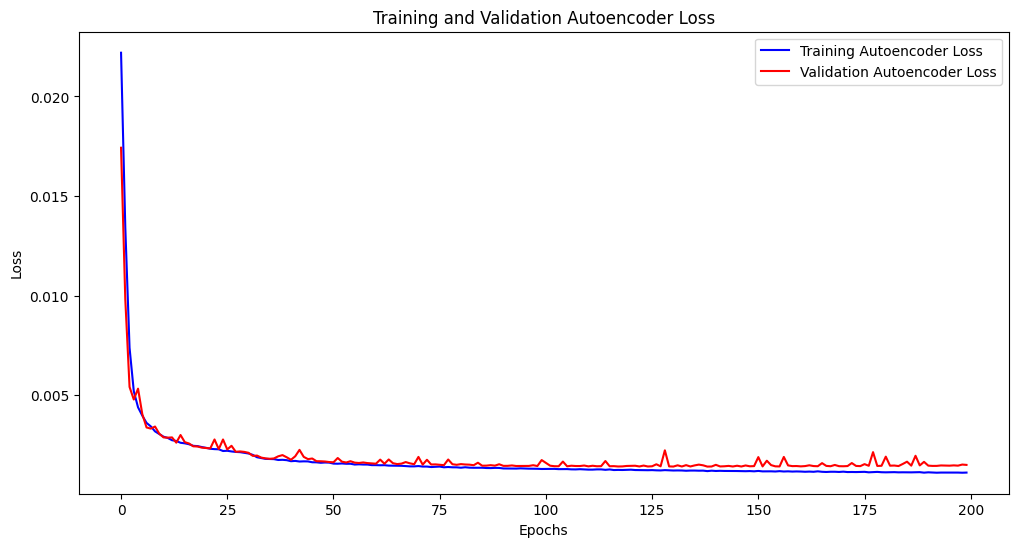

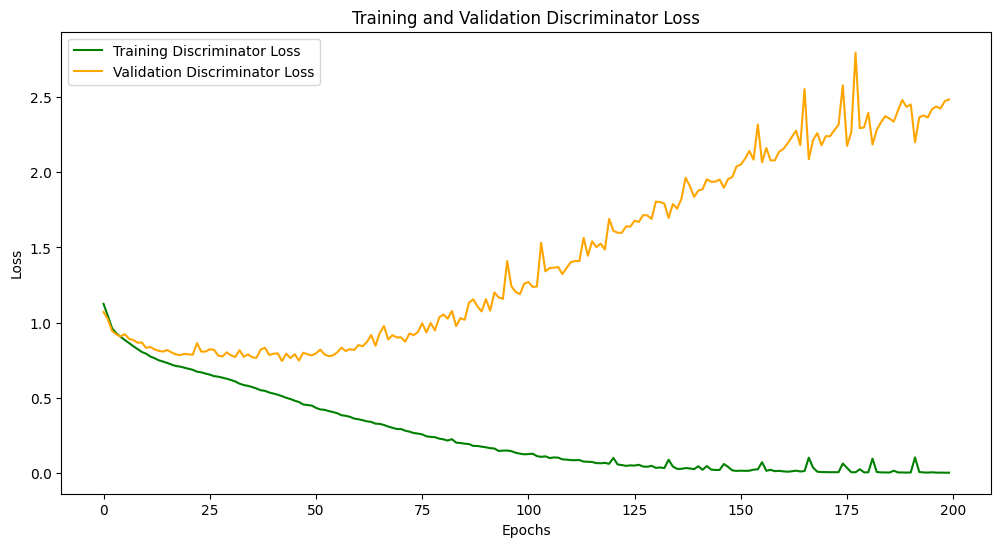

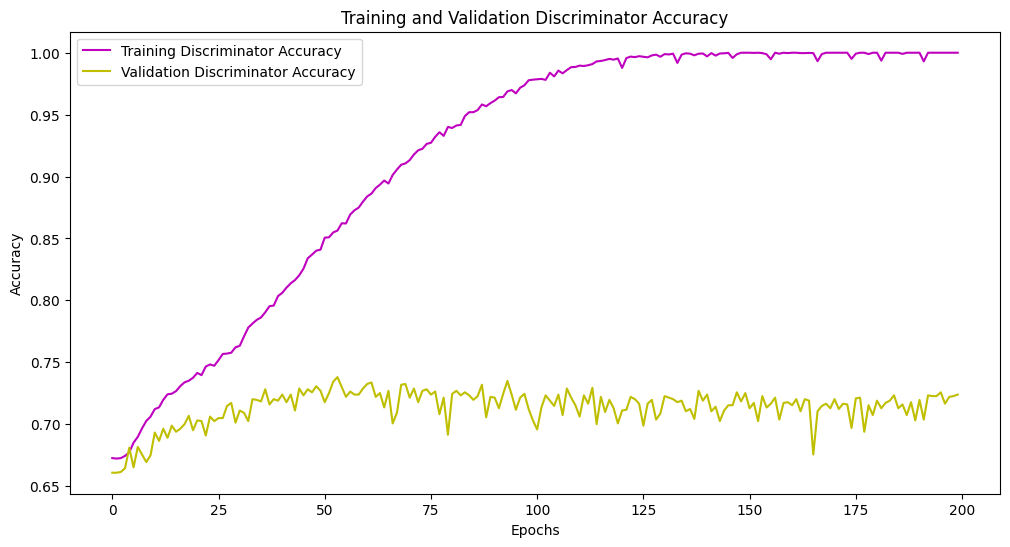

In [12]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(200))

# Autoencoder Loss plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, autoencoder_losses_epoch, label="Training Autoencoder Loss", color='b')
plt.plot(epochs, val_autoencoder_losses_epoch, label="Validation Autoencoder Loss", color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Autoencoder Loss")
plt.legend()
plt.show()

# Discriminator Loss plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, discriminator_losses_epoch, label="Training Discriminator Loss", color='g')
plt.plot(epochs, val_discriminator_losses_epoch, label="Validation Discriminator Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Discriminator Loss")
plt.legend()
plt.show()

# Discriminator Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, discriminator_acc_epoch, label="Training Discriminator Accuracy", color='m')
plt.plot(epochs, val_discriminator_acc_epoch, label="Validation Discriminator Accuracy", color='y')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Discriminator Accuracy")
plt.legend()
plt.show()
